<a href="https://colab.research.google.com/github/cesarniyo/PySpark-Big-Data/blob/master/Building_ML_models_with_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Big Data with PySpark

## Introduction 

### Project Overview

In this project, we will put into practice the key principles and techniques used into building a Machine Learing model using PySpark(a Python API for Apache Spark).
Apache Spark being an open-source, distributed computetion platform used for big data workloads. It uses in-memory caching and optimized query execution for fast queries against data of any size. 
In this work we will have a look on the interpretion of the requirements and necessary tasks to build, test, and optimize a number of  models including Regression, Decision Tree, Random Forest and Gradient Boost.


### Datasets description

In 1998, the Adventure Works Cycles company collected a large volume of data about their existing customers, including demographic features and information about purchases they have made. The company is particularly interested in analyzing customer data to determine any apparent relationships between demographic features known about the customers and the likelihood of a customer purchasing a bike. 

This data consists of three files, containing data that was collected on January 1st 1998.


AdvWorksCusts.csv
Customer demographic data consisting of the following fields:

- CustomerID (integer): A unique customer identifier.
- Title (string): The customer's formal title (Mr, Mrs, Ms, Miss Dr, etc.)
- FirstName (string): The customer's first name.
- MiddleName (string): The customer's middle name.
- LastName (string): The customer's last name.
- Suffix (string): A suffix for the customer name (Jr, Sr, etc.)
- AddressLine1 (string): The first line of the customer's home address.
- AddressLine2 (string): The second line of the customer's home address.
- City (string): The city where the customer lives.
- StateProvince (string): The state or province where the customer lives.
- CountryRegion (string): The country or region where the customer lives.
- PostalCode (string): The postal code for the customer's address.
- PhoneNumber (string): The customer's telephone number.
- BirthDate (date): The customer's date of birth in the format YYYY-MM-DD.
- Education (string): The maximum level of education achieved by the customer:
- Partial High School
- High School
- Partial College
- Bachelors
- Graduate Degree
- Occupation (string): The type of job in which the customer is employed:
- Manual
- Skilled Manual
- Clerical
- Management
- Professional
- Gender (string): The customer's gender (for example, M for male, F for female, etc.)
- MaritalStatus (string): Whether the customer is married (M) or single (S).
- HomeOwnerFlag (integer): A Boolean flag indicating whether the customer owns their own home (1) or not (0).
- NumberCarsOwned (integer): The number of cars owned by the customer.
- NumberChildrenAtHome (integer): The number of children the customer has who live at home.
- TotalChildren (integer): The total number of children the customer has.
- YearlyIncome (decimal): The annual income of the customer.


 AW_AveMonthSpend.csv
Sales data for existing customers, consisting of the following fields:

- CustomerID (integer): The unique identifier for the customer.
- AveMonthSpend (decimal): The amount of money the customer spends with Adventure Works Cycles on average each month.

AW_BikeBuyer.csv
Sales data for existing customers, consisting of the following fields:

- CustomerID (integer): The unique identifier for the customer.
- BikeBuyer (integer): A Boolean flag indicating whether a customer has previously purchased a bike (1) or not (0).

### Let's start by Installing the requeried Dependencies

In [0]:
# Install spark-related dependencies (Java, Hadoop and Spark)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz



In [2]:
# Install pyspark and findspark (Findspark in order to locate the spark in the system)
!pip install pyspark
!pip install -q findspark


     |████████████████████████████████| 215.7MB 63kB/s 
     |████████████████████████████████| 204kB 42.2MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.4-py2.py3-none-any.whl size=216130387 sha256=0cc4459d66ab0bf309e04d2049e3bad05a0a62bd1a299d6976cc9e0ed9d72e1f
  Stored in directory: /root/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471
Successfully built pyspark


In [0]:
# Set up required environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"


### Next we Import tools (from PySpark and more)

In [0]:
# Tools we need to connect to the Spark server, load our data, clean it, and prepare, execute, and evaluate a model

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark import SparkConf

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.sql.functions import isnan, when, count, col

import numpy as np
import pandas as pd


In [0]:
# Import and initialize findspark
import findspark
findspark.init()

In [6]:

# Point Colaboratory to your Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Downloading Data to Google Drive

In [0]:
#Load training data from local system
Features = pd.read_csv('AdvWorksCusts.csv')
RLabels = pd.read_csv('AW_AveMonthSpend.csv')
CLabels = pd.read_csv('AW_BikeBuyer.csv')

#concatinate all data into one table and save them on My Drive
df=pd.concat([Features,RLabels['AveMonthSpend'],CLabels['BikeBuyer']], axis=1, sort=False)
df.to_csv('/content/gdrive/My Drive/Datasets/dataset.csv',index=False)


## Set Constants

In [0]:
APP_NAME = "Customer Purchasing Behavior"
SPARK_URL = "local[*]"
RANDOM_SEED = 2018
TRAINING_DATA_RATIO = 0.7
RF_NUM_TREES = 10
RF_MAX_DEPTH = 4
RF_NUM_BINS = 32

In [0]:

# Connect to the Spark server
spark = SparkSession.builder.appName(APP_NAME).master(SPARK_URL).getOrCreate()
dataset="/content/gdrive/My Drive/Datasets/dataset.csv"
df = spark.read.csv(dataset, header = True, inferSchema = True)


In [10]:
# Checking on type( int or strings) of each feature in our dataset
df.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- FirstName: string (nullable = true)
 |-- MiddleName: string (nullable = true)
 |-- LastName: string (nullable = true)
 |-- Suffix: string (nullable = true)
 |-- AddressLine1: string (nullable = true)
 |-- AddressLine2: string (nullable = true)
 |-- City: string (nullable = true)
 |-- StateProvinceName: string (nullable = true)
 |-- CountryRegionName: string (nullable = true)
 |-- PostalCode: string (nullable = true)
 |-- PhoneNumber: string (nullable = true)
 |-- BirthDate: timestamp (nullable = true)
 |-- Education: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- HomeOwnerFlag: integer (nullable = true)
 |-- NumberCarsOwned: integer (nullable = true)
 |-- NumberChildrenAtHome: integer (nullable = true)
 |-- TotalChildren: integer (nullable = true)
 |-- YearlyIncome: integer (nullable = true)

In [11]:
#Displaying the head of the dataset
pd.DataFrame(df.take(5), columns=df.columns)#.transpose()

,CustomerID,Title,FirstName,MiddleName,LastName,Suffix,AddressLine1,AddressLine2,City,StateProvinceName,CountryRegionName,PostalCode,PhoneNumber,BirthDate,Education,Occupation,Gender,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,AveMonthSpend,BikeBuyer
0,11000,None,Jon,V,Yang,None,3761 N. 14th St,None,Rockhampton,Queensland,Australia,4700,1 (11) 500 555-0162,1966-04-08,Bachelors,Professional,M,M,1,0,0,2,137947,89,0
1,11001,None,Eugene,L,Huang,None,2243 W St.,None,Seaford,Victoria,Australia,3198,1 (11) 500 555-0110,1965-05-14,Bachelors,Professional,M,S,0,1,3,3,101141,117,1
2,11002,None,Ruben,None,Torres,None,5844 Linden Land,None,Hobart,Tasmania,Australia,7001,1 (11) 500 555-0184,1965-08-12,Bachelors,Professional,M,M,1,1,3,3,91945,123,0
3,11003,None,Christy,None,Zhu,None,1825 Village Pl.,None,North Ryde,New South Wales,Australia,2113,1 (11) 500 555-0162,1968-02-15,Bachelors,Professional,F,S,0,1,0,0,86688,50,0
4,11004,None,Elizabeth,None,Johnson,None,7553 Harness Circle,None,Wollongong,New South Wales,Australia,2500,1 (11) 500 555-0131,1968-08-08,Bachelors,Professional,F,S,1,4,5,5,92771,95,1


In [12]:
#Are our Classes perfectly balanced? (NO)
df.groupby('BikeBuyer').count().toPandas()

,BikeBuyer,count
0,1,5489
1,0,11030


## Prepare, clean and validate the data

In [13]:
# Displaying data shape before starting cleaning
print(f"The shape is {df.count():d} rows by {len(df.columns):d} columns.")

The shape is 16519 rows by 25 columns.


In [0]:
# Dropping unwanted features and inputs as needed
df = df.drop(df.BirthDate)

In [15]:
# Let's check the number of null values
null_counts = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) 
                         for c in df.columns]).toPandas().to_dict(orient='records')

print(f"We have {sum(null_counts[0].values()):d} null values in this dataset.")

We have 56176 null values in this dataset.


In [0]:
#dropping unwanted feature 
df = df.drop(df.Title)
df = df.drop(df.MiddleName)
df = df.drop(df.Suffix)
df = df.drop(df.AddressLine2)

# df = df.na.drop()



In [17]:
# Confirm there are no null values
null_counts = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) 
                         for c in df.columns]).toPandas().to_dict(orient='records')

print(f"We have {sum(null_counts[0].values()):d} null values in this dataset.")

We have 0 null values in this dataset.


In [18]:
# Looking at the data shape after cleaning 
print(f"The shape is {df.count():d} rows by {len(df.columns):d} columns.")

The shape is 16519 rows by 20 columns.


## Set up and run our classifier in Spark

In [19]:
# Checking on type[int or strings] of each feature in our dataset (After cleaning)
#df.dtypes
df.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- FirstName: string (nullable = true)
 |-- LastName: string (nullable = true)
 |-- AddressLine1: string (nullable = true)
 |-- City: string (nullable = true)
 |-- StateProvinceName: string (nullable = true)
 |-- CountryRegionName: string (nullable = true)
 |-- PostalCode: string (nullable = true)
 |-- PhoneNumber: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- HomeOwnerFlag: integer (nullable = true)
 |-- NumberCarsOwned: integer (nullable = true)
 |-- NumberChildrenAtHome: integer (nullable = true)
 |-- TotalChildren: integer (nullable = true)
 |-- YearlyIncome: integer (nullable = true)
 |-- AveMonthSpend: integer (nullable = true)
 |-- BikeBuyer: integer (nullable = true)



In [20]:
# Summary statistics for numeric variables
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
CustomerID,16519,20234.225195229734,5342.515987383602,11000,29482
HomeOwnerFlag,16519,0.6738906713481445,0.4688020251826776,0,1
NumberCarsOwned,16519,1.5009988498093105,1.13896240081262,0,4
NumberChildrenAtHome,16519,0.9920092015255161,1.5150483246404947,0,5
TotalChildren,16519,2.0062352442641807,1.6827356691512656,0,5
YearlyIncome,16519,78122.51153217508,39710.98571770291,9482,196511
AveMonthSpend,16519,72.40595677704462,27.285370492296273,22,176
BikeBuyer,16519,0.33228403656395666,0.4710464814690257,0,1


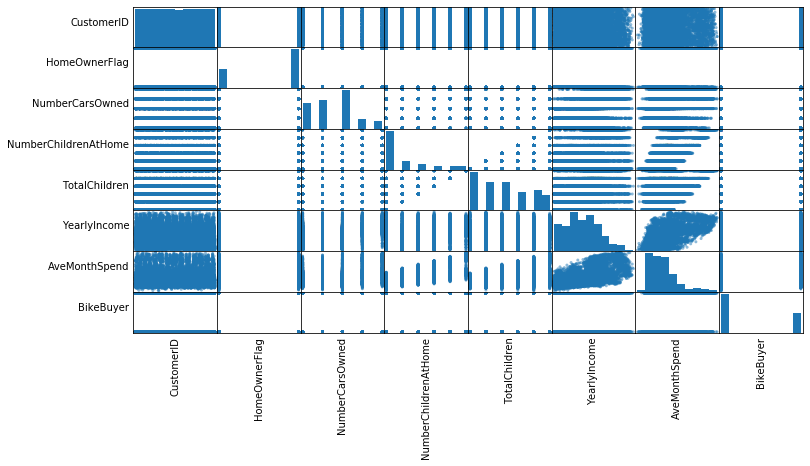

In [21]:
# Computing the Correlations between features
from pandas.plotting import scatter_matrix
numeric_data = df.select(numeric_features).toPandas()

axs = scatter_matrix(numeric_data, figsize=(12, 6));

# Rotate axis labels and remove axis ticks
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [22]:
# Selecting columns used for training
df = df.select('Education',
 'Occupation',
 'Gender',
 'MaritalStatus',
 'HomeOwnerFlag',
 'NumberCarsOwned',
 'NumberChildrenAtHome',
 'TotalChildren',
 'YearlyIncome',
 'AveMonthSpend',
 'BikeBuyer')
cols = df.columns
df.printSchema()


root
 |-- Education: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- HomeOwnerFlag: integer (nullable = true)
 |-- NumberCarsOwned: integer (nullable = true)
 |-- NumberChildrenAtHome: integer (nullable = true)
 |-- TotalChildren: integer (nullable = true)
 |-- YearlyIncome: integer (nullable = true)
 |-- AveMonthSpend: integer (nullable = true)
 |-- BikeBuyer: integer (nullable = true)



In [0]:
# Build the training indexers
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

# Defining categorical features
categoricalColumns = ['Education', 'Occupation', 'Gender', 'MaritalStatus']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

# Defining numerical features
numericCols = ['HomeOwnerFlag', 'NumberCarsOwned', 'NumberChildrenAtHome', 'TotalChildren', 'YearlyIncome', 'AveMonthSpend']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols

# Generating a labelIndexer 
label_stringIdx = StringIndexer(inputCol = 'BikeBuyer', outputCol = 'label')
stages += [label_stringIdx]

# Generating the indexed feature vector
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [24]:

from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages) 
pipelineModel = pipeline.fit(df)     # Chain indexers and the  models in a Pipeline
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- Education: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- HomeOwnerFlag: integer (nullable = true)
 |-- NumberCarsOwned: integer (nullable = true)
 |-- NumberChildrenAtHome: integer (nullable = true)
 |-- TotalChildren: integer (nullable = true)
 |-- YearlyIncome: integer (nullable = true)
 |-- AveMonthSpend: integer (nullable = true)
 |-- BikeBuyer: integer (nullable = true)



In [25]:
# Desplaying the Dataset after cleaning process
pd.DataFrame(df.take(5), columns=df.columns)#.transpose()

,label,features,Education,Occupation,Gender,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,AveMonthSpend,BikeBuyer
0,0.0,"(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",Bachelors,Professional,M,M,1,0,0,2,137947,89,0
1,1.0,"(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",Bachelors,Professional,M,S,0,1,3,3,101141,117,1
2,0.0,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",Bachelors,Professional,M,M,1,1,3,3,91945,123,0
3,0.0,"(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",Bachelors,Professional,F,S,0,1,0,0,86688,50,0
4,1.0,"(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",Bachelors,Professional,F,S,1,4,5,5,92771,95,1


In [26]:
# Split the data into training and tests sets
train, test = df.randomSplit([TRAINING_DATA_RATIO, 1 - TRAINING_DATA_RATIO], seed = RANDOM_SEED) 
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 11485
Test Dataset Count: 5034


# BUILDING THE MODELS

## Regression model

In [0]:
# Import the model from the Library
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train) # Train the model

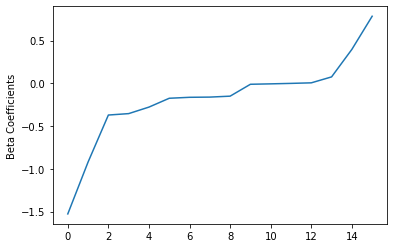

In [28]:
# Displaying the model better coefficient
import matplotlib.pyplot as plt
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

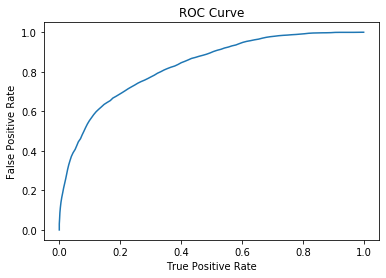

Training set areaUnderROC: 0.8294750871892838


In [29]:
# Displaying the model Performence (ROC)
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

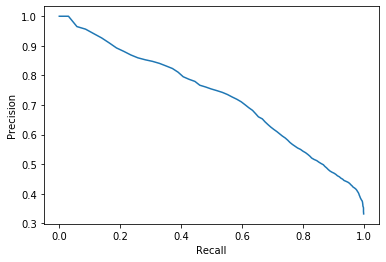

In [30]:
# Displaying the model Performence (Precision and Recall)
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

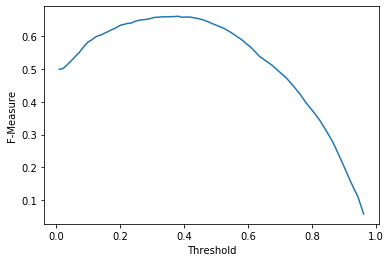

In [31]:
# Displaying the model Performence (F-Measure = F-Score)
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

In [32]:
# Make predictions
predictions = lrModel.transform(test)
predictions.select('Education', 'Occupation', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+----------+------------+-----+--------------------+----------+--------------------+
| Education|  Occupation|label|       rawPrediction|prediction|         probability|
+----------+------------+-----+--------------------+----------+--------------------+
|Bachelors |Professional|  0.0|[1.32429286775751...|       0.0|[0.78989504120501...|
|Bachelors |Professional|  0.0|[1.27313151583368...|       0.0|[0.78127834047849...|
|Bachelors |Professional|  0.0|[1.15399273346337...|       0.0|[0.76023945017912...|
|Bachelors |Professional|  0.0|[0.83118289114326...|       0.0|[0.69660498782662...|
|Bachelors |Professional|  0.0|[1.86177610068558...|       0.0|[0.86550383275784...|
|Bachelors |Professional|  0.0|[1.02492279122016...|       0.0|[0.73593038968931...|
|Bachelors |Professional|  0.0|[0.87533904301498...|       0.0|[0.70585542606189...|
|Bachelors |Professional|  0.0|[0.72751057904386...|       0.0|[0.67425874874377...|
|Bachelors |Professional|  0.0|[0.62307970189714...|       0.0|[0

## Evaluating the model 

In [33]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Select prediction, true label and compute test error
evaluator = BinaryClassificationEvaluator() # MulticlassClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8358222037321473


In [34]:
evaluator.getMetricName()

'areaUnderROC'

In [35]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8368928500312843


## Decision Tree model

In [36]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('Education', 'Occupation', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+----------+------------+-----+--------------+----------+--------------------+
| Education|  Occupation|label| rawPrediction|prediction|         probability|
+----------+------------+-----+--------------+----------+--------------------+
|Bachelors |Professional|  0.0|[3981.0,541.0]|       0.0|[0.88036267138434...|
|Bachelors |Professional|  0.0|[3981.0,541.0]|       0.0|[0.88036267138434...|
|Bachelors |Professional|  0.0|[3981.0,541.0]|       0.0|[0.88036267138434...|
|Bachelors |Professional|  0.0|[3981.0,541.0]|       0.0|[0.88036267138434...|
|Bachelors |Professional|  0.0|[3981.0,541.0]|       0.0|[0.88036267138434...|
|Bachelors |Professional|  0.0|[3981.0,541.0]|       0.0|[0.88036267138434...|
|Bachelors |Professional|  0.0|[3981.0,541.0]|       0.0|[0.88036267138434...|
|Bachelors |Professional|  0.0|[3981.0,541.0]|       0.0|[0.88036267138434...|
|Bachelors |Professional|  0.0|[3981.0,541.0]|       0.0|[0.88036267138434...|
|Bachelors |Professional|  0.0|[3981.0,541.0]|      

In [37]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.6372277159071514


In [38]:
evaluator.getMetricName()

'areaUnderROC'

## Random Forest model

In [39]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('Education', 'Occupation', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+----------+------------+-----+--------------------+----------+--------------------+
| Education|  Occupation|label|       rawPrediction|prediction|         probability|
+----------+------------+-----+--------------------+----------+--------------------+
|Bachelors |Professional|  0.0|[14.5689688098839...|       0.0|[0.72844844049419...|
|Bachelors |Professional|  0.0|[14.3403696240956...|       0.0|[0.71701848120478...|
|Bachelors |Professional|  0.0|[14.4946904673999...|       0.0|[0.72473452336999...|
|Bachelors |Professional|  0.0|[14.5689688098839...|       0.0|[0.72844844049419...|
|Bachelors |Professional|  0.0|[16.1094790794793...|       0.0|[0.80547395397396...|
|Bachelors |Professional|  0.0|[14.5770159407420...|       0.0|[0.72885079703710...|
|Bachelors |Professional|  0.0|[14.5770159407420...|       0.0|[0.72885079703710...|
|Bachelors |Professional|  0.0|[14.5770159407420...|       0.0|[0.72885079703710...|
|Bachelors |Professional|  0.0|[14.7313367840463...|       0.0|[0

In [40]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8320480955225569


In [41]:
evaluator.getMetricName()

'areaUnderROC'

In [42]:
print(rf.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

## Gradient-boosted Tree model

In [43]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('Education', 'Occupation', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+----------+------------+-----+--------------------+----------+--------------------+
| Education|  Occupation|label|       rawPrediction|prediction|         probability|
+----------+------------+-----+--------------------+----------+--------------------+
|Bachelors |Professional|  0.0|[0.31398312837277...|       0.0|[0.65202817418672...|
|Bachelors |Professional|  0.0|[0.31398312837277...|       0.0|[0.65202817418672...|
|Bachelors |Professional|  0.0|[0.31398312837277...|       0.0|[0.65202817418672...|
|Bachelors |Professional|  0.0|[0.30405834292165...|       0.0|[0.64751107305717...|
|Bachelors |Professional|  0.0|[1.07368594457440...|       0.0|[0.89542293435818...|
|Bachelors |Professional|  0.0|[0.50898224374608...|       0.0|[0.73457591671319...|
|Bachelors |Professional|  0.0|[0.50898224374608...|       0.0|[0.73457591671319...|
|Bachelors |Professional|  0.0|[0.59270671589685...|       0.0|[0.76591975678359...|
|Bachelors |Professional|  0.0|[0.59270671589685...|       0.0|[0

In [44]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8427595366103409


In [45]:
evaluator.getMetricName()

'areaUnderROC'

In [46]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

### Sweeping model parameters for optimization

In [47]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.8451073313136417

## Conclusion

In this Project (STILL UNDER CONSTRUCTION) our goal is to build a best ML model to predict weather a customer will buy or not by Bicycle. Therefore to get there we started with several data preprocessing techniques including; feature selection, investing if any collinealy in the dataset, defining and preprocessing both categorical and numerical features, generating a labelIndexer and indexed feature vector in order to get data ready for model build process.

so far our candidate algorithms have yeild following results:
- Regression model ROC   83.5%,
- Decision Tree model ROC  63.7%, 
- Random Forest model ROC  83.3% and 
- Gradient Boost model ROC  84.5%.

Our next steps include dealing with data imbalance that came with the dataset also considering using other model improvement techniques